# Regression task


Imports

In [1]:
import configparser
import pandas as pd
from sklearn.linear_model import LinearRegression
import logging
import matplotlib.pyplot as plt


Read the configuration file

In [2]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

Configure a logger

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel(level=config['Logging']['level'])

## Prepare the data

Load the dataset

In [4]:
data_fname = config['RegressionData']['data_file']
logger.info(f"Loading data from file: {data_fname}")
df_input = pd.read_excel(data_fname)
logger.info(f"Loading completed. Data shape: {df_input.shape}")
df_input.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Trim the variable names to the first occurrence of an opening bracket and remove trailing spaces

In [5]:
df_input.rename(columns={key: key.split('(')[0].rstrip(' ') for key in df_input.keys()}, inplace=True)
df_input.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


split dataset into input and target


In [6]:
df_input.keys()

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age',
       'Concrete compressive strength'],
      dtype='object')

In [7]:
target_var = df_input.keys()[int(config['RegressionData']['target_column'])]
target_var

'Concrete compressive strength'

In [8]:
df_target = df_input.loc[:, target_var]
df_input.drop(target_var, axis=1, inplace=True)
input_vars = list(df_input.keys())
input_vars

['Cement',
 'Blast Furnace Slag',
 'Fly Ash',
 'Water',
 'Superplasticizer',
 'Coarse Aggregate',
 'Fine Aggregate',
 'Age']

In [9]:
n = len(input_vars)  # number of input variables
nt = n + 1           # number of all variables (including the target)

## Data visualisation

Display historgams of all variables

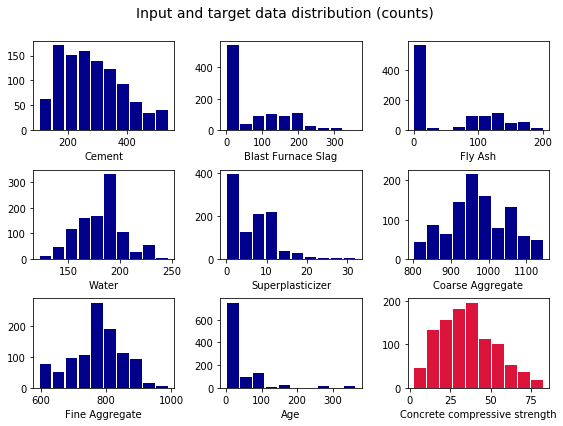

In [10]:
fig, axes = plt.subplots(nt//3 + (1 if nt%3 else 0), 3, figsize=(8, 6))

def hist(ax, data, xlabel, **kwargs):
    ax.hist(data, bins=10, rwidth=0.9, **kwargs)
    ax.set_xlabel(xlabel)

for i, input_var in enumerate(input_vars):
    hist(axes[i//3, i%3], df_input.loc[:, input_var], input_var, color='darkblue', lw=1)    
    
hist(axes[-1, n%3], df_target, target_var, color='crimson')

fig.suptitle("Input and target data distribution (counts)", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()


## Regression
Define a multivariate linear regression model and perform the fit on the data

In [11]:
fitter = LinearRegression()
fitter.fit(df_input, df_target)

print(f"Score: {fitter.score(df_input, df_target):.3f}")


Score: 0.615


Fit coefficients

In [12]:
coefs = pd.DataFrame(data=fitter.coef_.reshape(1,-1), columns=input_vars)
coefs

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,0.119785,0.103847,0.087943,-0.150298,0.290687,0.01803,0.020154,0.114226


Fit intercept

In [13]:
intercept = fitter.intercept_
intercept

-23.163755811078957

Regression equation

In [14]:
spacer = '\n' + 4*'\t'
eq = f'{spacer}+ '.join(map(lambda var: f'({coefs.loc[0, var]:.3f}) * <{var}>', coefs.keys()))
print(f"<{target_var}> = {eq}")

<Concrete compressive strength> = (0.120) * <Cement>
				+ (0.104) * <Blast Furnace Slag>
				+ (0.088) * <Fly Ash>
				+ (-0.150) * <Water>
				+ (0.291) * <Superplasticizer>
				+ (0.018) * <Coarse Aggregate>
				+ (0.020) * <Fine Aggregate>
				+ (0.114) * <Age>


## Visualise regression results

Display a set of 2D plot depicting the target variable as a function of each of the input variables

In [15]:
d = df_input
min_, max_, mean_ = (s.to_frame().transpose() for s in [d.min(), d.max(), d.mean()])
df_input_minmax = pd.concat([min_, max_])
df_input_minmax.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,102.0,0.0,0.0,121.75,0.0,801.0,594.0,1.0
0,540.0,359.4,200.1,247.00,32.2,1145.0,992.6,365.0


In [16]:
target_mean = df_target.mean()
target_mean

35.8178358261136

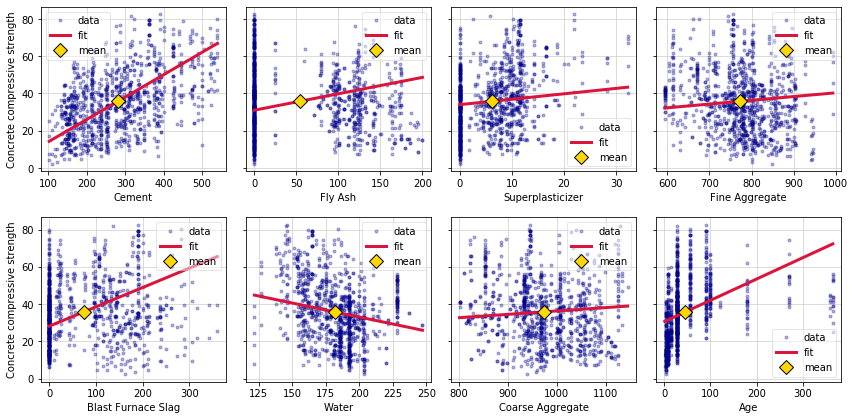

In [17]:
fig, axes = plt.subplots(2, n//2 + n%2, figsize=(12, 6), sharey='all')

for i, input_var in enumerate(input_vars):
    ax = axes[i%2, i//2]
    
    ax.plot(df_input.loc[:,input_var], df_target, '.', color='darkblue', label='data', alpha=0.3)
    
    xdata_fit = df_input_minmax.loc[:, input_var]
    xdata_mean = mean_[input_var]
    
    def _predict(x):
        return intercept + coefs.loc[0, input_var] * x
        
    mean_correction = _predict(xdata_mean) - target_mean
    ydata_fit = _predict(xdata_fit) - mean_correction
    ax.plot(xdata_fit, ydata_fit, color='crimson', label='fit', lw=3)
    
    ax.plot(df_input.loc[:,input_var].mean(), df_target.mean(), 'D', markerfacecolor='gold', ms=10,
            markeredgewidth=1, markeredgecolor='k', label='mean')
    
    ax.legend(fancybox=True, framealpha=0.5)
    ax.grid(color='lightgray')
    ax.set_xlabel(input_var)
    if not i//2:
        ax.set_ylabel(target_var)
fig.tight_layout()
plt.show()